In this notebook, we compare the distribution of the GLM MFX statistic obtained by Monte Carlo simulation with its theoretical distribution. GLM MFX is performed either using FLAME1 (form FSL) or using FLAME1 where the computation of the weights being is done manually from the estimates provided by FSL.

In [1]:
import nibabel as nib
import os
import numpy as np
import scipy
import pandas as pd
import scipy.stats
from distribution_plots import *

## Description of the Monte Carlo simulation setup
Study level contrast estimates (denoted $\beta_i$'s) and contrast variance estimates (denoted $\sigma_i$'s) were simulated according to:
$$
\beta_i \sim \mathcal{N}(0, \sigma_i^2+\tau^2)
$$

$$
s^2_i \sim \chi^2_{n-1}*\frac{\sigma_i^2}{n-1}
$$

with 
$$
\sigma_i^2 = \frac{\sigma^2*a_i}{n}
$$

where:
 - $\tau^2=1$ is the between-study variance, 
 - $\sigma_i^2$ is the variance of contrast estimate for study i (i.e. the within-study variance divided by $n$) and 
 - $n=20$ is the number of subjects per studies.
 
3 different simulation schemes were computed:
 - 'diff_1.5': $\sigma^2_i \in \{0.6, 0.9, 1.3, 2, 3\}$ `% computed as 1.5.^[0:4]*1.55/mean(1.5.^[0:4])`
 - 'diff': $\sigma^2_i \in \{0.25, 0.5, 1, 2, 4\}$ 
 - 'diff_3': $\sigma^2_i \in \{0.1, 0.2, 0.6, 1.7, 5.2\}$ `% computed as 3.^[0:4]*1.55/mean(3.^[0:4])`
 
A total of $38*30*30*30$ random sampling were computed.

## Load simulation results

In [2]:
# Simulation parameters
nrep = 38; # 38 repeats are available
nsimuperrep = 30*30*30
nreal = nrep*nsimuperrep # Total number of realisations

tau2 = 1 # Between-study variance
nsubjects = 20 # Number of subjects per study

varcope_sigma2 = [0.25, 0.5, 1, 2, 4]
sigma2 = dict(('{num:02d}'.format(num=int(t*nsubjects)), 
               '$\\tau^2 = 1, \sigma^2_i = ' + str(t) + '$')  
              for t in varcope_sigma2) # Possible within-study variances (constant across studies)

kstudies = 25 # Number of studies in the meta-analysis (one-sample)
dof = kstudies - 1 # Degrees of freedom

In [3]:
# Load the data
base_dir = '/Volumes/camille/IBMA_simu/'

wth_n20 = dict()

hat_taus = {k: [] for k in sigma2.keys()} # mean_random_effects_var1.nii.gz concatenated across (independent) runs & voxels
tstats = {k: [] for k in sigma2.keys()} # tstat1.nii.gz concatenated across (independent) runs & voxels
zstats = {k: [] for k in sigma2.keys()} # zstat1.nii.gz concatenated across (independent) runs & voxels
meta_varcopes = {k: [] for k in sigma2.keys()} # varcope1.nii.gz concatenated across (independent) runs & voxels
meta_copes = {k: [] for k in sigma2.keys()} # cope1.nii.gz concatenated across (independent) runs & voxels
weights = dict() # weights.nii.gz concatenated across (independent) runs & voxels
study_varcopes = dict() # varcopes.nii.gz concatenated across (independent) runs & voxels

for wth in sigma2.keys():
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=r), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 
                                       'mean_random_effects_var1.nii.gz')).get_data().flatten()
    hat_taus[wth] = np.append(hat_taus[wth], data_array)
    t_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'tstat1.nii.gz')).get_data().flatten()
    tstats[wth] = np.append(tstats[wth], t_data_array)
    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'varcope1.nii.gz')).get_data().flatten()
    meta_varcopes[wth] = np.append(meta_varcopes[wth], varcope_array)
    cope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'cope1.nii.gz')).get_data().flatten()
    meta_copes[wth] = np.append(meta_copes[wth], cope_array)

    weights_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'weights1.nii.gz')).get_data().reshape(-1,kstudies)
    if wth not in weights:
        weights[wth] = weights_array
    else:
        weights[wth] = np.append(weights[wth], weights_array, axis=0)

    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'varcope.nii.gz')).get_data().reshape(-1,kstudies)
    if wth not in study_varcopes:
        study_varcopes[wth] = varcope_array
    else:
        study_varcopes[wth] = np.append(study_varcopes[wth], varcope_array, axis=0)
        
        
for wth in hat_taus:
    hat_taus[wth] = np.expand_dims(hat_taus[wth], axis=1)

In [4]:
wth_todisp = ['diff', '05', '80'] # Settings to be displayed

In [5]:
# Recompute tstat manually
print(tstats['05'].shape)
print(tstats['05'].shape[0]*25)
print(weights['05'].shape)
print(study_varcopes['05'].shape)

print(hat_taus['05'].shape)
sum_wth_btw = study_varcopes['05'] + hat_taus['05']



print(study_varcopes['05'][1,14] + hat_taus['05'][1])
print(sum_wth_btw[1,14])

(1026000,)
25650000
(1026000, 25)
(1026000, 25)
(1026000, 1)
[ 0.88523805]
0.885238051414


In [9]:
kappa_i = 1/sum_wth_btw
print(kappa_i[897987])
print(weights['05'][897987])
print(np.isclose(weights['05'][897987,13],kappa_i[897987,13]))
print(np.all(np.isclose(weights['05'], kappa_i)))

sum_kappa_i = np.sum(kappa_i, axis=1)
print(np.isclose(np.sum(weights['05'], axis=1),sum_kappa_i))
print(np.all(np.isclose(weights['05'], kappa_i)))


meta_varcope_manual = 1/sum_kappa_i

[ 1.96022994  2.33551495  1.84311692  1.85152325  1.79236608  2.32810221
  1.50681536  2.36790223  2.28429983  1.93417347  2.22887725  1.79005813
  1.48274271  1.96132325  1.88514632  2.07429528  1.63315524  2.14149076
  1.76149218  1.77666139  1.86125503  1.80738279  2.3113106   1.57912885
  1.98808916]
[ 1.22383595  1.4581387   1.15071845  1.15596676  1.11903298  1.45351064
  0.94075429  1.4783591   1.42616343  1.20756805  1.39156127  1.1175921
  0.92572498  1.22451854  1.1769588   1.29505062  1.01963246  1.33700299
  1.09975743  1.10922801  1.16204262  1.12840843  1.44302714  0.98590201
  1.2412293 ]
False
False
[False False False ..., False False False]
False


In [7]:
print(meta_varcope_manual[897987])
print(meta_varcopes['05'][897987])
print(meta_varcopes['05'].shape)
print(meta_varcope_manual.shape)
print(np.isclose(meta_varcopes['05'][897987],meta_varcope_manual[897987]))
print(np.all(np.isclose(meta_varcope_manual, meta_varcopes['05'])))

0.0206243173942
0.0206243172288
(1026000,)
(1026000,)
True
True


## Problem statement

Issue: P-values obtained under the null hypothesis on simulated data presenting varying within-study variance are invalid (first plot below). 

The problem gets better for smaller variations in within-study variances (second plot) and worse for larger variations (third plot).


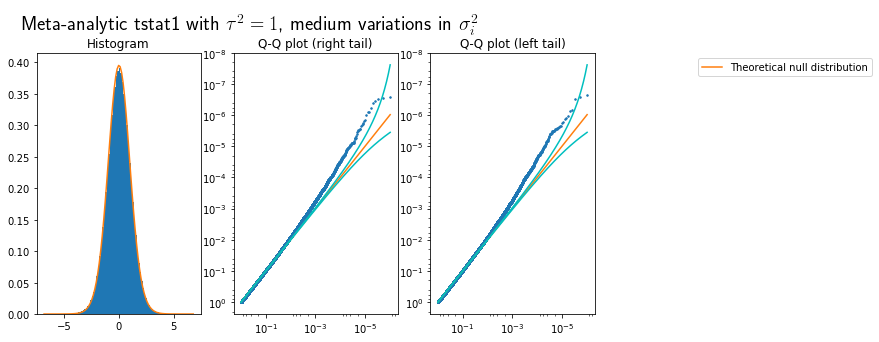

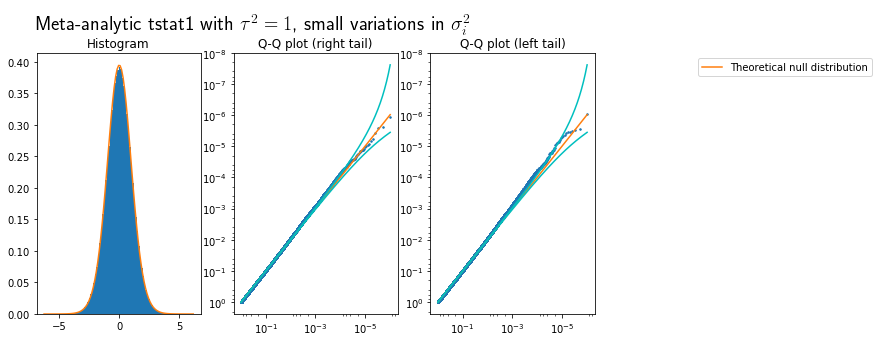

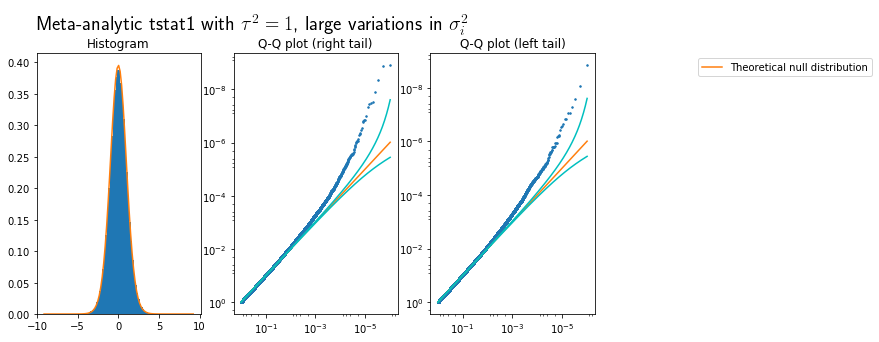

In [5]:
for wth in wth_todisp:
    t_distribution_plot(tstats[wth], 'Meta-analytic tstat1 with ' + sigma2[wth], dof)

## Distribution of the numerator of the T-statistic

Here we look at the distribution of the numerator of the meta-analysic t-statistic which corresponds to the `cope1.nii.gz` file generated at the meta-analytic level.

The theoretical distribution of `cope1.nii.gz` under the null is computed below.

### Theoretical distribution of the meta-analysis cope under H0

With MFX GLM under the null the meta-analysis cope (denoted $\gamma$) follows:
$$
\gamma \sim \mathcal{N}(0, \frac{1}{\sum \kappa_i})
$$
with $\kappa_i = 1/(\tau^2 + \sigma_i^2)$

For the different simulation settings:
 - diff': with $\sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$ $\gamma \sim \mathcal{N}(0, \frac{1}{1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5})$
 - diff_1.5': with $\sigma^2_i \in  \{0.6,0.9,1.3,2,3\}$ $\gamma \sim \mathcal{N}(0, \frac{1}{1/1.6 + 1/1.9 + 1/2.3 + 1/3 + 1/4 + /1.6 + 1/1.9 + 1/2.3 + 1/3 + 1/4 + /1.6 + 1/1.9 + 1/2.3 + 1/3 + 1/4 + /1.6 + 1/1.9 + 1/2.3 + 1/3 + 1/4 + /1.6 + 1/1.9 + 1/2.3 + 1/3 + 1/4 })$
 - diff_3': with $\sigma^2_i \in  \{0.1,0.2,0.6,1.7,5.2\}$ $\gamma \sim \mathcal{N}(0, \frac{1}{1/1.1 + 1/1.2 + 1/1.6 + 1/2.7 + 1/6.2 + 1/1.1 + 1/1.2 + 1/1.6 + 1/2.7 + 1/6.2 + 1/1.1 + 1/1.2 + 1/1.6 + 1/2.7 + 1/6.2 + 1/1.1 + 1/1.2 + 1/1.6 + 1/2.7 + 1/6.2 + 1/1.1 + 1/1.2 + 1/1.6 + 1/2.7 + 1/6.2 })$

We denoted by $k=25$ the number of studies included in the meta-analysis.

In [6]:
tau2 = 1
kstudies = 25
cope_th_var = dict()

def get_mfx_th_variance(tau2, sigma2_i):
    sigma2_i_ratios = [1/(tau2 + x) for x in sigma2_i]
    th_var_diff = 1/sum(sigma2_i_ratios)
    return(th_var_diff)

# From os.path.join(wth_n20['diff'], os.pardir, 'simu.mat') we see:
wth_sigma_a = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
sigma2_i = [x * 0.25 for x in wth_sigma_a]
cope_th_var['diff'] = get_mfx_th_variance(tau2, sigma2_i)
orig_a_mean = np.mean(wth_sigma_a[0:5])

wth_sigma_a_15 = np.power(1.5, range(5))
wth_sigma_a_15 = wth_sigma_a_15*orig_a_mean/np.mean(wth_sigma_a_15)
sigma2_i_15 = [x * 0.25 for x in np.repeat(wth_sigma_a_15,5)]
cope_th_var['diff_1.5'] = get_mfx_th_variance(tau2, sigma2_i_15)

wth_sigma_a_3 = np.power(3, range(5))
wth_sigma_a_3 = wth_sigma_a_3*orig_a_mean/np.mean(wth_sigma_a_3)
sigma2_i_3 = [x * 0.25 for x in np.repeat(wth_sigma_a_3,5)]
cope_th_var['diff_3'] = get_mfx_th_variance(tau2, sigma2_i_3)

print(cope_th_var)

{'diff': 0.08, 'diff_1.5': 0.091797834904345912, 'diff_3': 0.068005069337694748}


### Observed distribution of the meta-analytic cope
We plot the observed distribution of the `cope1.nii.gz` against the theoretical distribution under the null are provided below.

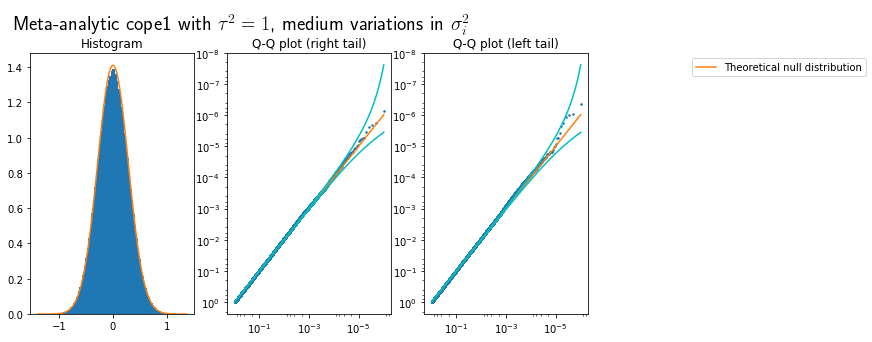

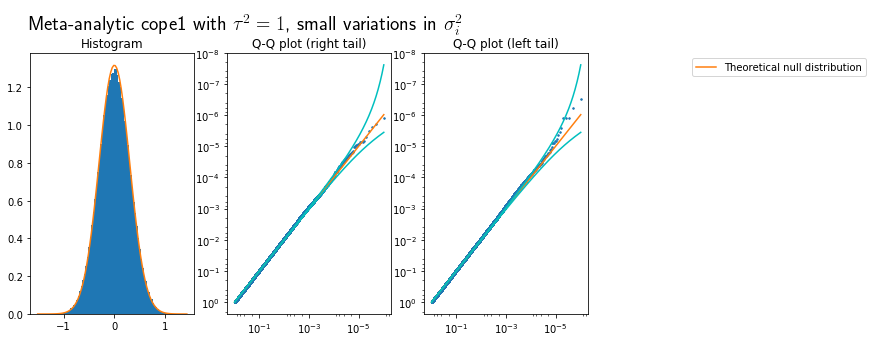

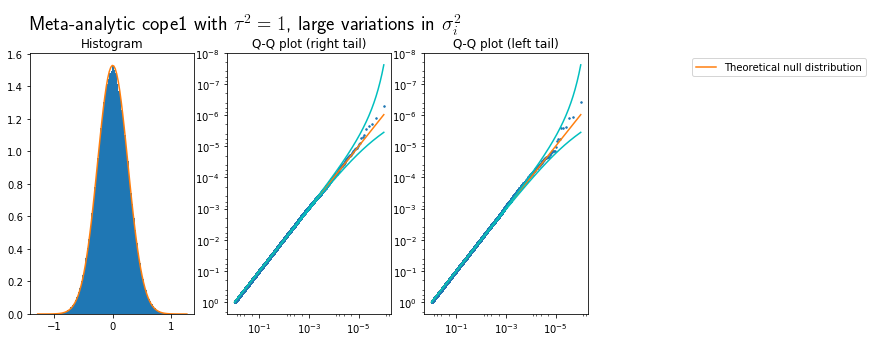

In [7]:
for wth in wth_todisp:
    z_distribution_plot(
        meta_copes[wth], # cope to display
        'Meta-analytic cope1 with ' + sigma2[wth], # Title
        0, np.sqrt(cope_th_var[wth]) # Parameters of the theoretical Normal distribution
    )

## Distribution of the denominator of the T-statistic

Here we look at the distribution of the denomerator of the meta-analysis t-statistic which corresponds to the `varcope1.nii.gz` file generated at the meta-analytic level.

The theoretical distribution of `varcope1.nii.gz` under the null is computed below. 

### Theoretical distribution of the meta-analysis varcope under H0

With MFX GLM under the null the meta-analysis varcope (denoted $Var(\gamma)$) is assumed to follow:
$$
Var(\gamma) \sim \chi^2_{k-1} \frac{1}{(k-1) \sum \kappa_i}
$$
with $\kappa_i = 1/(\tau^2 + \sigma_i^2)$

For the different simulation settings:
 - diff: with $\sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$ $Var(\gamma) \sim \chi^2_{k-1} \frac{1}{1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5} \frac{1}{k-1} $
 
where $k=25$ is the number of studies included in the meta-analysis.

### Observed distribution of the meta-analytic varcope
We plot the observed distribution of the `varcope1.nii.gz` against the theoretical distribution under the null are provided below.

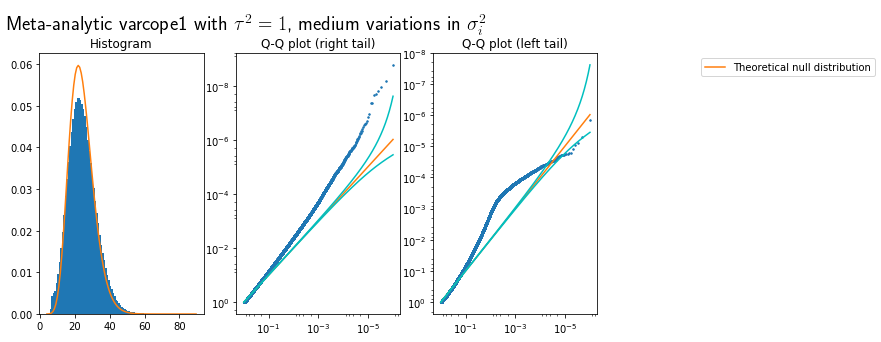

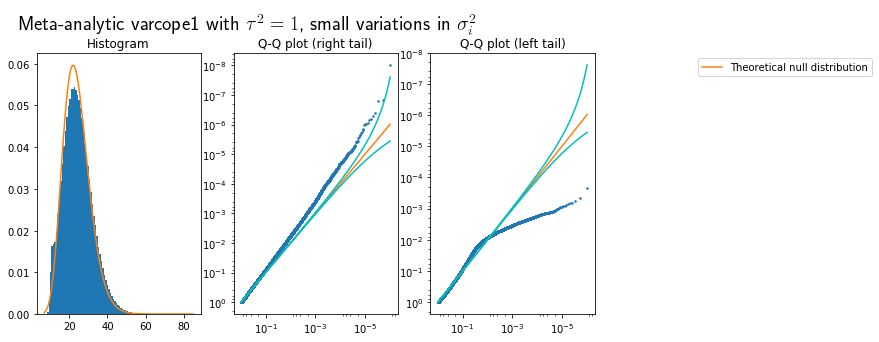

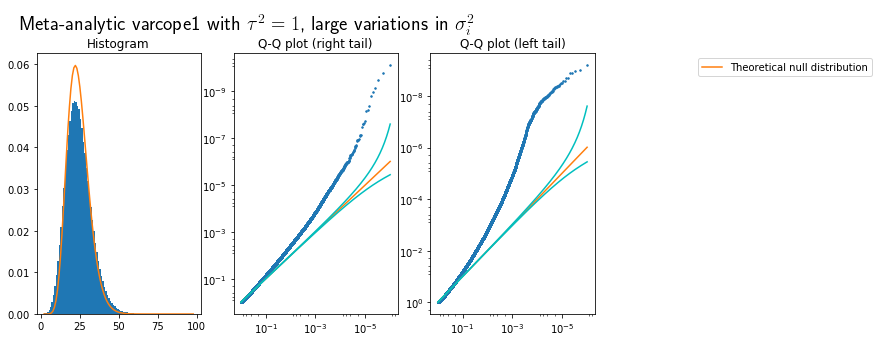

In [8]:
for wth in wth_todisp:
    chi2_distribution_plot(
        meta_varcopes[wth]*dof/(cope_th_var[wth]), # varcope to display scaled by sigma2/dof
        'Meta-analytic varcope1 with ' + sigma2[wth], 
        dof # Parameters of the theoretical Chi2 distribution
    )

### Look for bias in the meta-analysis varcopes

In [9]:
for wth in wth_todisp:
    _mu = np.mean(meta_varcopes[wth])
    print('Mean meta-analytic varcope1 (over ' + str(nreal) + ' realisations) for ' + wth + ' = ' + 
          "{0:.4f}".format(_mu) + ' / True varcope1=' + "{0:.4f}".format(cope_th_var[wth]))

Mean meta-analytic varcope1 (over 1026000 realisations) for diff = 0.0810 / True varcope1=0.0800
Mean meta-analytic varcope1 (over 1026000 realisations) for diff_1.5 = 0.0935 / True varcope1=0.0918
Mean meta-analytic varcope1 (over 1026000 realisations) for diff_3 = 0.0686 / True varcope1=0.0680


### Estimated degrees of freedom for the meta-analysis varcopes using Satterwaite approximation   

In [10]:
for wth in wth_todisp:
    _mu = np.mean(meta_varcopes[wth])
    _sigma2 = np.var(meta_varcopes[wth])
    nu = 2*_mu*_mu/(_sigma2)
    c = (_sigma2)/(2*_mu)
    print('Estimated dof of meta-analytic varcope1 (over ' + str(nreal) + ' realisations) for \'' + wth + '\': ' + 
          ' nu=' + "{0:.1f}".format(nu) + '/ True nu=' + str(dof) )

Estimated dof of meta-analytic varcope1 (over 1026000 realisations) for 'diff':  nu=18.5/ True nu=24
Estimated dof of meta-analytic varcope1 (over 1026000 realisations) for 'diff_1.5':  nu=20.9/ True nu=24
Estimated dof of meta-analytic varcope1 (over 1026000 realisations) for 'diff_3':  nu=17.7/ True nu=24
